In [1]:
import requests
import json
import numpy as np
import pandas as pd
import nltk 
import matplotlib
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from string import punctuation
import re
import numpy as np
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer

In [2]:
url = 'https://newsapi.org/v2/everything?'
api_key = "c31d9f572e5d47eeaae9d16463d0c921"

In [3]:
def get_articles(file):
    '''
    This is a helper function the extract articles from the newsapi dataset
    ''' 


    article_results = [] 
    for i in range(len(file)):
        article_dict = {}
        article_dict['title'] = file[i]['title']
        article_dict['author'] = file[i]['author']
        article_dict['source'] = file[i]['source']
        article_dict['description'] = file[i]['description']
        article_dict['content'] = file[i]['content']
        article_dict['pub_date'] = file[i]['publishedAt']
        article_dict['url'] = file[i]["url"]
        article_dict['photo_url'] = file[i]['urlToImage']
        article_results.append(article_dict)
    return article_results

def get_news_articles(source: str, topic: str):
    '''
    Returns the dataframe from newsource and topic
    Input: str,str
    Output: pd frame
    '''

    assert isinstance(source,str)
    assert isinstance(topic,str)

    
    parameters_headlines = {
    'q': topic,
    'sortBy':'popularity',
    'pageSize': 100,
    'apiKey': api_key,
    'language': 'en',
    'domains' : format(source)  
    }

    # making the API call 
    response_headline = requests.get(url, params = parameters_headlines)
    response_json_headline = response_headline.json()
    responses = response_json_headline["articles"]
    # transforminf the data from JSON dictionary to a pandas data frame
    news_articles_df = pd.DataFrame(get_articles(responses))
    # printing the head to check the format and the working of the get_articles function
    return news_articles_df

In [4]:
cnn_covidf = get_news_articles("cnn.com","covid")     #cnn covid frame
fox_covidf = get_news_articles("foxnews.com","covid") #fox covid frame

In [5]:
def get_senti_frame(frame = None, download = False):

    '''
    Returns a dataframe with sentiment scores extracted using nltk vader
    Input: pd frame, bool
    Output: pd frame
    '''
    
    assert isinstance(download,bool)

    from nltk.sentiment.vader import SentimentIntensityAnalyzer as SIA
    if(download):nltk.download('vader_lexicon')
    sia = SIA()
    results = []
    titles = frame["title"]

    for line in titles:
        pol_score = sia.polarity_scores(line)
        pol_score['headline'] = line
        results.append(pol_score)
    
    df = pd.DataFrame.from_records(results)
    df['label'] = 0
    df.loc[df['compound'] > 0.2, 'label'] = 1
    df.loc[df['compound'] < -0.2, 'label'] = -1
    return df

In [6]:
cnn_sframe = get_senti_frame(cnn_covidf,False)
fox_sframe = get_senti_frame(fox_covidf,False)

/usr/local/lib/python3.7/dist-packages/nltk/twitter/__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


Here we show the processed sentiment dataframe, where 0 represents neutral, -1 represents negative, and 1 represents postive. Sentiment were calculated based on the headlines of the news

In [7]:
cnn_sframe.head()

,neg,neu,pos,compound,headline,label
0,0.000,1.000,0.000,0.0000,These Southern states have fully vaccinated le...,0
1,0.000,1.000,0.000,0.0000,Republican gubernatorial candidate Allen West ...,0
2,0.169,0.390,0.442,0.6369,Indian homegrown Covid-19 shot wins WHO emerge...,1
3,0.000,0.729,0.271,0.3818,Opinion: How to protect pregnant people from C...,1
4,0.000,1.000,0.000,0.0000,Conservative radio host says he wanted to catc...,0


Next, we show some samples of the postively labeled  ande negative sentiment headlines

In [8]:
positive_cnn = cnn_sframe[cnn_sframe["label"] == 1]["headline"]
print(positive_cnn.iloc[0])
print(positive_cnn.iloc[2])
print(positive_cnn.iloc[5])

Indian homegrown Covid-19 shot wins WHO emergency use approval
Federal judge allows health care workers in New York to apply for religious exemptions to Covid-19 vaccine mandate
Top Biden official held calls with airline executives to push for vaccine mandates


In [9]:
positive_cnn = cnn_sframe[cnn_sframe["label"] == -1]["headline"]
print(positive_cnn.iloc[0])
print(positive_cnn.iloc[2])
print(positive_cnn.iloc[5])

Biden administration blames ongoing pandemic fears for disappointing jobs report
Fired Washington State head football coach to file lawsuit over 'unjust and unlawful' termination
Opinion: Texas governor's blatant hypocrisy puts lives at risk


In [46]:
import matplotlib.pyplot as plt
import seaborn as sns

def plot(df,title:str):
    '''
      Given a sentiment frame, plot the sentiment
    '''
  
    assert isinstance(title,str)

    fig, ax = plt.subplots(figsize=(8, 8))

    counts = df.label.value_counts(normalize=True) * 100

    sns.barplot(x=counts.index, y=counts, ax=ax)

    ax.set_xticklabels(['Negative', 'Neutral', 'Positive'])
    ax.set_ylabel("Percentage")
    ax.set_title(title)
    plt.show()

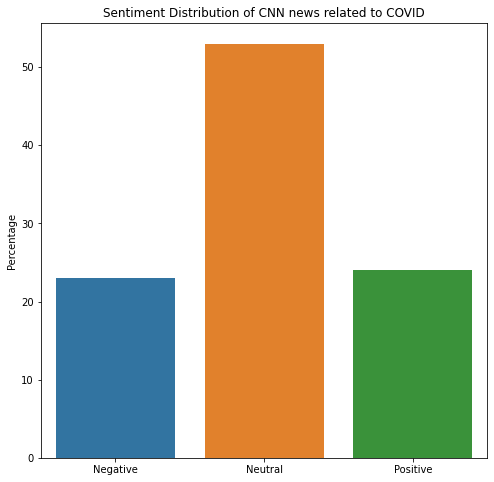

In [47]:
plot(cnn_sframe,"Sentiment Distribution of CNN news related to COVID")

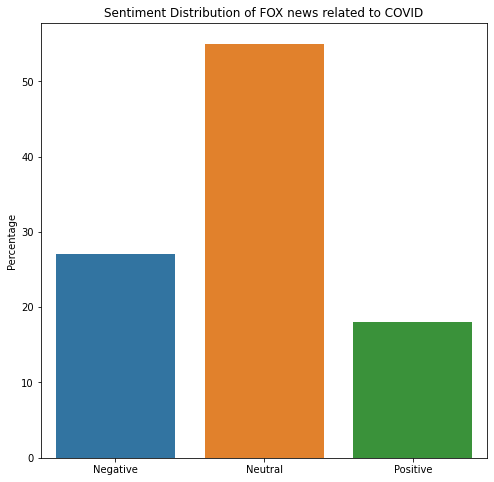

In [48]:
plot(fox_sframe,"Sentiment Distribution of FOX news related to COVID")

In [49]:
def get_word_freq(sframe,label,topk = 20,download = False):
    '''
    Returns the top words in the headlines given the label{1(pos), -1(negative)}
    Input: data frame,data frame, int, int, bool
          sframe: sentiment frame, df: news dataframe
    Output: list of dict 
    '''

    assert isinstance(label,int)
    assert isinstance(download,bool)

    from nltk.corpus import stopwords
    from nltk.tokenize import word_tokenize, RegexpTokenizer
    tokenizer = RegexpTokenizer(r'\w+')
    if download: nltk.download('stopwords')

    stop_words = stopwords.words('english')
    tokens = []


    pos_lines = list(sframe[sframe.label == label].headline)

    for line in pos_lines:
        toks = tokenizer.tokenize(line)
        toks = [t.lower() for t in toks if t.lower() not in stop_words]
        tokens.extend(toks)
    
    pos_freq = nltk.FreqDist(tokens)
    return pos_freq.most_common(topk) if topk is not None else pos_freq.most_common()

    

In [50]:
cnn_pos = get_word_freq(cnn_sframe,label = 1, topk = None)
print(cnn_pos[:20])
cnn_neg = get_word_freq(cnn_sframe,label = -1, topk = None)
print(cnn_neg[:20])

[('covid', 9), ('19', 5), ('vaccinated', 5), ('vaccine', 4), ('get', 3), ('use', 2), ('opinion', 2), ('people', 2), ('new', 2), ('mandate', 2), ('even', 2), ('show', 2), ('biden', 2), ('us', 2), ('ease', 2), ('travel', 2), ('restrictions', 2), ('travelers', 2), ('allow', 2), ('tourists', 2)]
[('covid', 9), ('19', 6), ('washington', 3), ('pandemic', 2), ('report', 2), ('state', 2), ('head', 2), ('football', 2), ('coach', 2), ('vaccine', 2), ('died', 2), ('j', 2), ('opinion', 2), ('texas', 2), ('new', 2), ('robert', 2), ('durst', 2), ('murder', 2), ('us', 2), ('china', 2)]


In [51]:
fox_pos = get_word_freq(fox_sframe,label = 1, topk = None)
print(cnn_pos[:20])
fox_neg = get_word_freq(fox_sframe,label = -1, topk = None)
print(cnn_neg[:20])

[('covid', 9), ('19', 5), ('vaccinated', 5), ('vaccine', 4), ('get', 3), ('use', 2), ('opinion', 2), ('people', 2), ('new', 2), ('mandate', 2), ('even', 2), ('show', 2), ('biden', 2), ('us', 2), ('ease', 2), ('travel', 2), ('restrictions', 2), ('travelers', 2), ('allow', 2), ('tourists', 2)]
[('covid', 9), ('19', 6), ('washington', 3), ('pandemic', 2), ('report', 2), ('state', 2), ('head', 2), ('football', 2), ('coach', 2), ('vaccine', 2), ('died', 2), ('j', 2), ('opinion', 2), ('texas', 2), ('new', 2), ('robert', 2), ('durst', 2), ('murder', 2), ('us', 2), ('china', 2)]


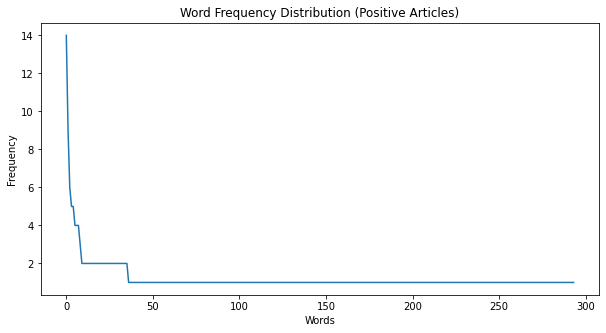

In [52]:
positive = sorted(fox_pos + cnn_pos,key = lambda i: -i[1])
y_val = [x[1] for x in positive]
fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Positive Articles)")
plt.show()

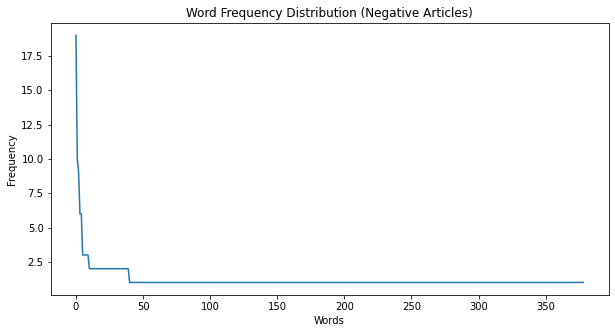

In [53]:
negative =sorted(fox_neg + cnn_neg,key = lambda i: -i[1])
y_val = [x[1] for x in negative]
fig = plt.figure(figsize=(10,5))
plt.plot(y_val)

plt.xlabel("Words")
plt.ylabel("Frequency")
plt.title("Word Frequency Distribution (Negative Articles)")
plt.show()